
#Лабораторная работа 1
##Метрические Алгоритмы


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

##Задание 1
Датасет

In [21]:
X, Y = make_classification(n_samples=250, n_features=3,
                           n_informative=3, n_classes=5,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=None)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=50,
                                                    random_state=0)

Метод ближайшего соседа

In [22]:
models = []
for n_neighbors in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    models.append(model)

In [23]:
def draw_results(X_test, predictions):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for idx in range(len(X_test)):
        point = X_test[idx]
        color = ''
        if predictions[idx] == 0:
            color = '#ff7f0e'
        elif predictions[idx] == 1:
            color = '#1f77b4'
        elif predictions[idx] == 2:
            color = '#d62728'
        elif predictions[idx] == 3:
            color = '#9467bd'
        elif predictions[idx] == 4:
            color = '#17becf'

        ax.scatter(point[0], point[1], point[2], c = color)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

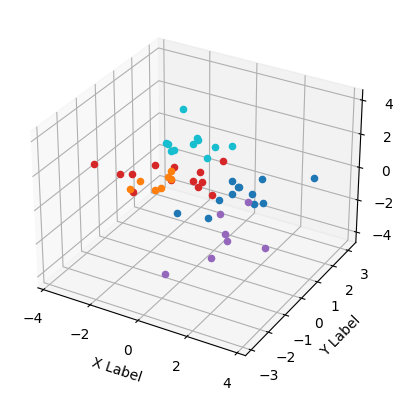

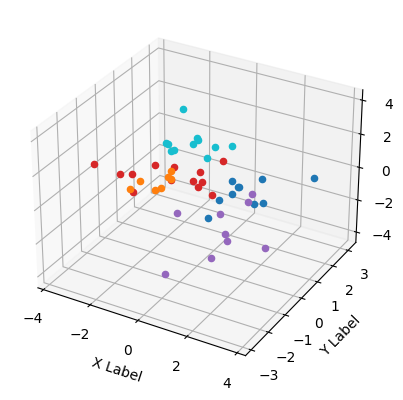

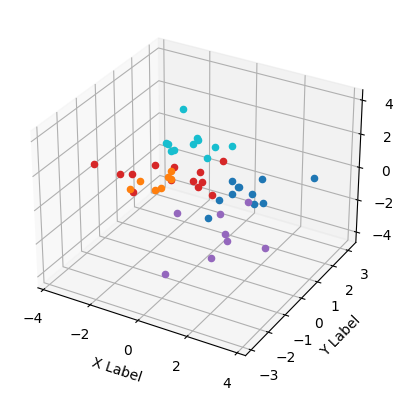

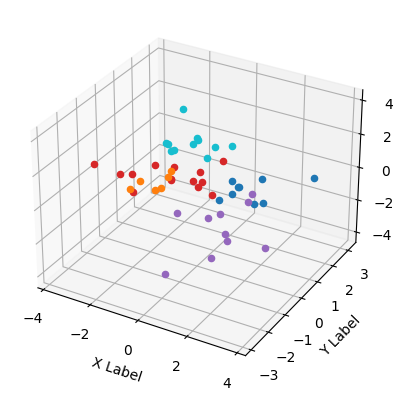

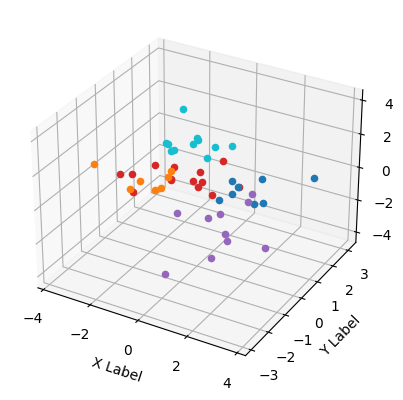

In [24]:
for i in range(5, 10):
    predictions = models[i].predict(X_test)
    draw_results(X_test, predictions)

#Метод k-ближайших взвешенных соседей

In [13]:
def func(distance):
    ret = np.ones_like(distance)
    k = ret.shape[1]
    for i in range(k):
        ret[:, i] *= (k-i)/k
    return ret

In [18]:
models = []
for n_neighbors in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=func)
    model.fit(X_train, Y_train)
    models.append(model)

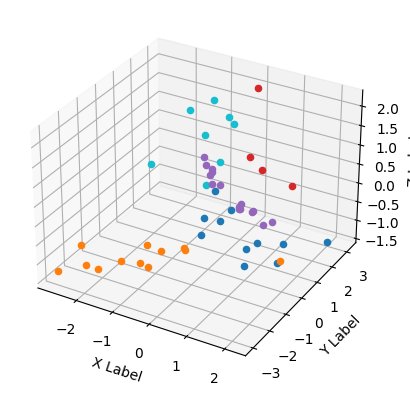

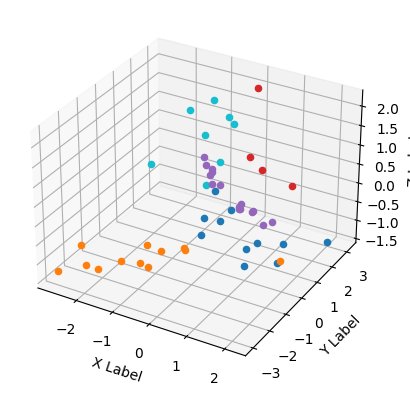

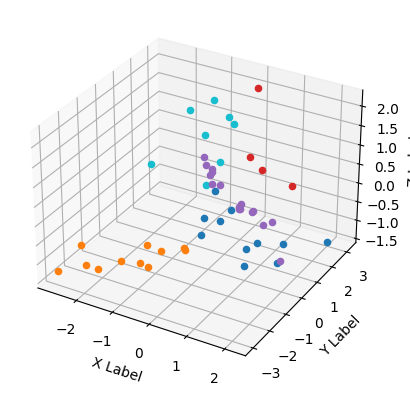

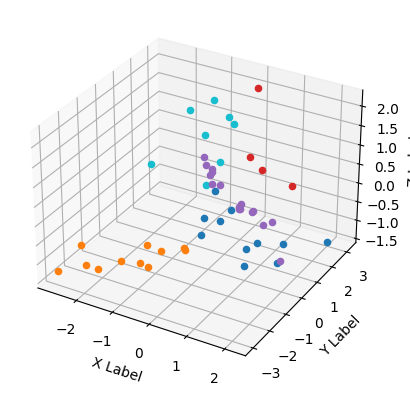

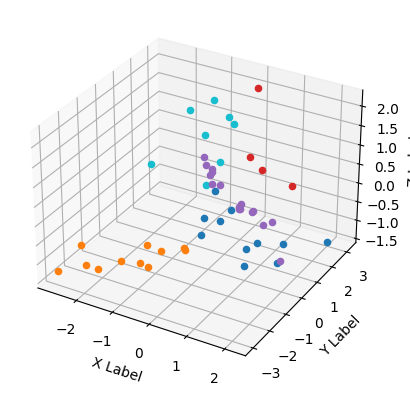

In [20]:
for i in range(5, 10):
    predictions = models[i].predict(X_test)
    draw_results(X_test, predictions)

#Ядерный алгоритм (Метод окна Парзена)

In [25]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

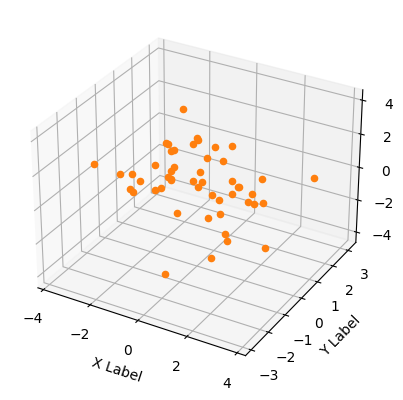

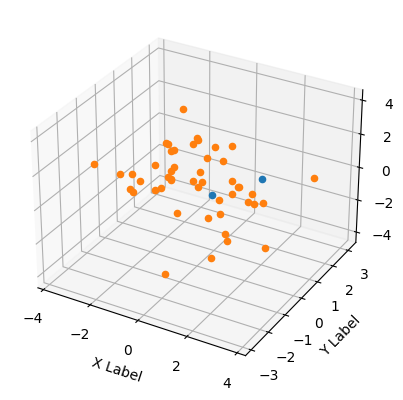

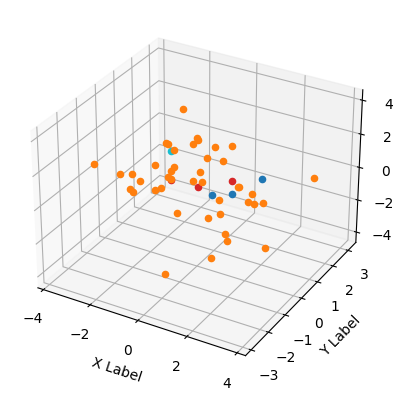

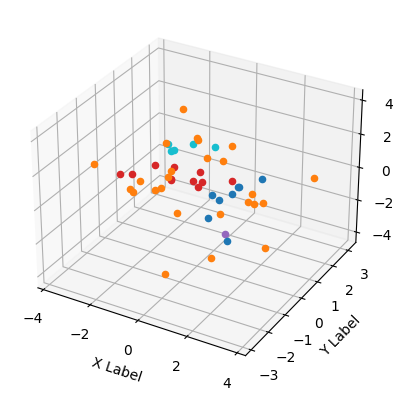

In [27]:
for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
    model = KNeighborsClassifier(n_neighbors=len(X_train), weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    draw_results(X_test, predictions)

#Оптимизация по выбору ширины окна

In [31]:
import optuna

def objective(trial):
    h_opt = trial.suggest_float("h_opt", 0.01, 100, log=True)
    model3 = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h_opt)) # обучение с коэфициентом h
    model3.fit(X_train, Y_train)
    return 1 / model3.score(X_test, Y_test, sample_weight=None)

optuna.logging.disable_default_handler() #Отключить логирование
study = optuna.create_study()
study.optimize(objective, n_trials=400)

best_params = study.best_params
found_h_opt = best_params["h_opt"]
model3 = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=found_h_opt)) # обучение с коэфициентом h
model3.fit(X_train, Y_train)
print("Ширина окна h: {:0.3f}, Точность: {:0.3f}".format(found_h_opt, model3.score(X_test, Y_test, sample_weight=None)))

Ширина окна h: 0.901, Точность: 0.740


In [32]:
from torchvision import datasets, transforms
import torch

import os

In [47]:
dataset_folder = '../content/media/'

classes = ['happy', 'sad', 'angry']

In [48]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
ImageEmbedder = mp.tasks.vision.ImageEmbedder
ImageEmbedderOptions = mp.tasks.vision.ImageEmbedderOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = ImageEmbedderOptions(
    base_options=BaseOptions(model_asset_path='./mobilenet_v3_small.tflite'),
    quantize=True,
    running_mode=VisionRunningMode.IMAGE)

In [49]:
with ImageEmbedder.create_from_options(options) as embedder:
    image_embeddings = []
    image_labels = []
    for cl in range(len(classes)):
        for im_file in os.listdir(dataset_folder + classes[cl]):
            if im_file.endswith('jpg'):
                mp_image = mp.Image.create_from_file(dataset_folder + classes[cl] + '/' + im_file)
                embedding_result = embedder.embed(mp_image)
                image_embeddings.append(embedding_result.embeddings[0].embedding)
                image_labels.append(cl)

In [50]:
model = KNeighborsClassifier(n_neighbors=2)

In [51]:
model.fit(np.array(image_embeddings), np.array(image_labels))

KNeighborsClassifier(n_neighbors=2)

In [53]:
from sklearn.metrics import accuracy_score

preds = model.predict(np.array(image_embeddings))
accuracy_score(np.array(image_labels), preds)

0.6481481481481481